# PROYECTO FINAL PORTAFOLIOS

Paquetes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
from scipy.stats import norm
import scipy.optimize as sco

### Supuestos

In [2]:
Port = 7 # numero de acciones del portafolio
rf = 0.05 # tasa libre de riesgo
pr = 0.1 # premio por riesgo
mi = 10_000_000 # Monto invertido

Importar datos

In [3]:
market = pd.read_excel('ipc7.xlsx', index_col=0,sheet_name="Precios") #, index_col=0
market.columns = [x.replace(" MF Equity",'').replace(" INDEX",'') for x in market]
c = len(market.columns)
acciones = random.sample(range(c-1), k=Port)
acciones.append(c-1)
market = market.iloc[:,acciones]

## Rendimiento esperado diario y anual bajo los siguientes modelos: 

In [4]:
rend = (market / market.shift() - 1).dropna()
rend_M = rend
rend = rend.drop(['MEXBOL'],axis=1)
titulos = rend.columns

### Modelo de rendimiento promedio constante 

In [5]:
def mean_anu(series): return series.mean() * 252
def var_anu(series): return series.var() * 252
def std_anu(series): return np.sqrt(series.var() * 252)
def rend_portf(matriz):return rend.agg(['mean',mean_anu, 'var',var_anu,'std',std_anu])   

In [6]:
res = rend_portf(rend)
print('Estadisticos')
res.style.format("{:.2%}")

Estadisticos


,ASURB,ELEKTRA*,GAPB,GMEXICOB,KIMBERA,PE&OLES*,ALPEKA
mean,0.05%,0.15%,0.05%,0.05%,0.01%,0.04%,0.00%
mean_anu,12.35%,36.68%,12.78%,13.38%,1.67%,11.11%,0.13%
var,0.02%,0.04%,0.02%,0.03%,0.02%,0.05%,0.03%
var_anu,5.64%,10.79%,5.87%,8.19%,6.18%,13.81%,6.79%
std,1.50%,2.07%,1.53%,1.80%,1.57%,2.34%,1.64%
std_anu,23.75%,32.85%,24.23%,28.62%,24.85%,37.16%,26.06%


### Modelo CAPM 

In [7]:
res = rend_portf(rend)
print('Estadisticos')
res.style.format("{:.4f}")

Estadisticos


,ASURB,ELEKTRA*,GAPB,GMEXICOB,KIMBERA,PE&OLES*,ALPEKA
mean,0.0005,0.0015,0.0005,0.0005,0.0001,0.0004,0.0000
mean_anu,0.1235,0.3668,0.1278,0.1338,0.0167,0.1111,0.0013
var,0.0002,0.0004,0.0002,0.0003,0.0002,0.0005,0.0003
var_anu,0.0564,0.1079,0.0587,0.0819,0.0618,0.1381,0.0679
std,0.0150,0.0207,0.0153,0.0180,0.0157,0.0234,0.0164
std_anu,0.2375,0.3285,0.2423,0.2862,0.2485,0.3716,0.2606


In [8]:
betas = []
for x in rend.columns:
    X = rend_M[['MEXBOL']]
    Y = rend_M[[x]]
    lm = LinearRegression()
    lm.fit(X, Y)
    betas.append(lm.coef_[0][0])

In [9]:
clasif = ['Agresiva' if x > 1 else 'Defensiva' for x in betas]
rende = [rf + pr * x for x in betas]
capm = pd.DataFrame({
    'Título': titulos,
    'Betas': betas,
    'Clasificación': clasif,
    'Rend_esperado': rende
})
capm.style.format({'Rend_esperado':"{:.2%}"})

,Título,Betas,Clasificación,Rend_esperado
0,ASURB,0.916168,Defensiva,14.16%
1,ELEKTRA*,0.376368,Defensiva,8.76%
2,GAPB,0.930147,Defensiva,14.30%
3,GMEXICOB,1.12197,Agresiva,16.22%
4,KIMBERA,0.818112,Defensiva,13.18%
5,PE&OLES*,1.02807,Agresiva,15.28%
6,ALPEKA,0.609526,Defensiva,11.10%


## Matriz varianza-covarianza 

In [10]:
print('Matriz varianza-covarianza')
rend.cov()

Matriz varianza-covarianza


,ASURB,ELEKTRA*,GAPB,GMEXICOB,KIMBERA,PE&OLES*,ALPEKA
ASURB,0.000224,2.436981e-05,0.000132,6.284605e-05,0.000048,0.000061,0.000047
ELEKTRA*,0.000024,4.283130e-04,0.000017,-7.371033e-07,0.000026,0.000022,0.000016
GAPB,0.000132,1.683988e-05,0.000233,6.983020e-05,0.000053,0.000059,0.000038
GMEXICOB,0.000063,-7.371033e-07,0.000070,3.251424e-04,0.000055,0.000127,0.000052
KIMBERA,0.000048,2.563850e-05,0.000053,5.467728e-05,0.000245,0.000063,0.000028
PE&OLES*,0.000061,2.184248e-05,0.000059,1.267608e-04,0.000063,0.000548,0.000053
ALPEKA,0.000047,1.577429e-05,0.000038,5.173850e-05,0.000028,0.000053,0.000270


## Utilizando los rendimientos esperados bajo el modelo CAPM, construye: 

In [11]:
def rend_esp(pond): return np.dot(mean,pond)
def var(series): return series.var() * 252
def vol(pond): return np.sqrt(np.dot(pond.T,np.dot(cov,pond)))
def pstats(pond):
    pret = rend_esp(pond)
    pvol = vol(pond)
    return np.array([pret,pvol,(pret-rf)/pvol])
def min_sharpe(pond):
    return -pstats(pond)[2]

### Con ventas en corto 

In [12]:
short = True

Simulación

In [13]:
rend = (np.log(market / market.shift())).dropna()
rend_M = rend
rend = rend.drop(['MEXBOL'],axis=1)
mean = [rf + pr * x for x in betas]
cov = rend.cov() * 252
n = len(titulos)
sh = -1 if short else 0

In [14]:
prets = []
pvols = []

for p in range(int(5e4)):
    pond = np.random.random(n)
    pond /= np.sum(pond)
    prets.append(rend_esp(pond))
    pvols.append(vol(pond))
    
prets = np.array(prets)
pvols = np.array(pvols)

In [15]:
frontera = np.linspace(min(mean)*.75,max(mean)*1.25,1000)
rendsf = []
volsf = []

for p in frontera:
    cons = ({'type': 'eq', 'fun': lambda x: 1 - np.sum(x) },
           {'type': 'eq', 'fun': lambda x: np.sum(x * mean) - p })
    bnds = tuple((sh,1) for x in range(n))
    opts2 = sco.minimize(vol, n * [1. / n], method = 'SLSQP', bounds = bnds, constraints = cons)
    opt2 = pstats(opts2['x'])
    rendsv = opt2[0]
    volsv = opt2[1]
    rendsf.append(rendsv)
    volsf.append(volsv)
rendsf = np.array(rendsf)
volsf = np.array(volsf)

## Encuentra el portafolio riesgoso óptimo (maximiza el coeficiente de Sharpe) 

In [16]:
cons = ({'type': 'eq', 'fun': lambda x: 1 -np.sum(x) })
bnds = tuple((sh,1) for x in range(n))
opts = sco.minimize(min_sharpe, n * [1. / n], method = 'SLSQP', bounds = bnds, constraints = cons)
sharpe_opt = pstats(opts['x'])
R_esp = sharpe_opt[0]
print('Rendimiento esperado: {:.2%}\nVolatilidad: {:.2%}\nSharpe: {:.4}'.format(sharpe_opt[0],sharpe_opt[1],sharpe_opt[2]))
print('-----------------------------')
pesos = pd.DataFrame([x for x in opts['x']],index=titulos,columns=['Peso']).T
pesos.style.format("{:.2%}")

Rendimiento esperado: 13.91%
Volatilidad: 15.44%
Sharpe: 0.5769
-----------------------------


,ASURB,ELEKTRA*,GAPB,GMEXICOB,KIMBERA,PE&OLES*,ALPEKA
Peso,18.23%,5.53%,17.30%,21.65%,19.61%,7.37%,10.32%


In [17]:
u = np.linspace(0,sharpe_opt[1]*2,10)
u_ = [rf + sharpe_opt[2] * u]

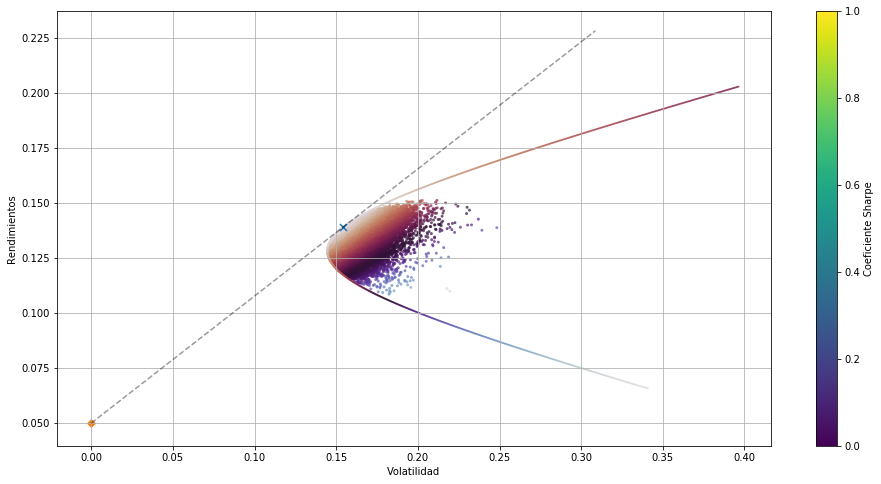

In [18]:
plt.figure(figsize=(16,8))
plt.scatter(pvols,prets,c=(prets-rf) / pvols, marker = 'o',s = 4,cmap = 'twilight',alpha = 0.6)
plt.scatter(volsf,rendsf,c= (rendsf-rf) / volsf, marker = '.',s = 4,cmap = 'twilight',alpha = 0.6)
plt.scatter(sharpe_opt[1],sharpe_opt[0], marker = 'x',s = 50,cmap = 'twilight',alpha = 1)
plt.scatter(0,rf,marker='D',s=30)
plt.plot(u,u_[0],c='black',alpha=.4,linestyle = '--') 
plt.grid(True)
plt.xlabel('Volatilidad')
plt.ylabel('Rendimientos')
plt.colorbar(label = 'Coeficiente Sharpe')
plt.show()


### Sin ventas en corto

In [19]:
short = False

Simulación

In [20]:
rend = (np.log(market / market.shift())).dropna()
rend_M = rend
rend = rend.drop(['MEXBOL'],axis=1)
mean = rend_capm = [rf + pr * x for x in betas]
cov = rend.cov() * 252
cov_d = rend.cov()
n = len(titulos)
sh = -1 if short else 0

In [21]:
prets = []
pvols = []

for p in range(int(5e4)):
    pond = np.random.random(n)
    pond /= np.sum(pond)
    prets.append(rend_esp(pond))
    pvols.append(vol(pond))
    
prets = np.array(prets)
pvols = np.array(pvols)

In [22]:
frontera = np.linspace(min(mean)*.75,max(mean)*1.25,1000)
rendsf = []
volsf = []

for p in frontera:
    cons = ({'type': 'eq', 'fun': lambda x: 1 - np.sum(x) },
           {'type': 'eq', 'fun': lambda x: np.sum(x * mean) - p })
    bnds = tuple((sh,1) for x in range(n))
    opts2 = sco.minimize(vol, n * [1. / n], method = 'SLSQP', bounds = bnds, constraints = cons)
    opt2 = pstats(opts2['x'])
    rendsv = opt2[0]
    volsv = opt2[1]
    rendsf.append(rendsv)
    volsf.append(volsv)
rendsf = np.array(rendsf)
volsf = np.array(volsf)

## Encuentra el portafolio riesgoso óptimo (maximiza el coeficiente de Sharpe) 

In [23]:
cons = ({'type': 'eq', 'fun': lambda x: 1 -np.sum(x) })
bnds = tuple((sh,1) for x in range(n))
opts = sco.minimize(min_sharpe, n * [1. / n], method = 'SLSQP', bounds = bnds, constraints = cons)
sharpe_opt = pstats(opts['x'])
R_esp = sharpe_opt[0]
print('Rendimiento esperado: {:.2%}\nVolatilidad: {:.2%}\nSharpe: {:.4}'.format(sharpe_opt[0],sharpe_opt[1],sharpe_opt[2]))
print('-----------------------------')
pesos = pd.DataFrame([x for x in opts['x']],index=titulos,columns=['Peso']).T
pesos.style.format("{:.2%}")

Rendimiento esperado: 13.91%
Volatilidad: 15.44%
Sharpe: 0.5769
-----------------------------


,ASURB,ELEKTRA*,GAPB,GMEXICOB,KIMBERA,PE&OLES*,ALPEKA
Peso,18.25%,5.51%,17.26%,21.63%,19.60%,7.40%,10.36%


In [24]:
u = np.linspace(0,sharpe_opt[1]*2,10)
u_ = [rf + sharpe_opt[2] * u]

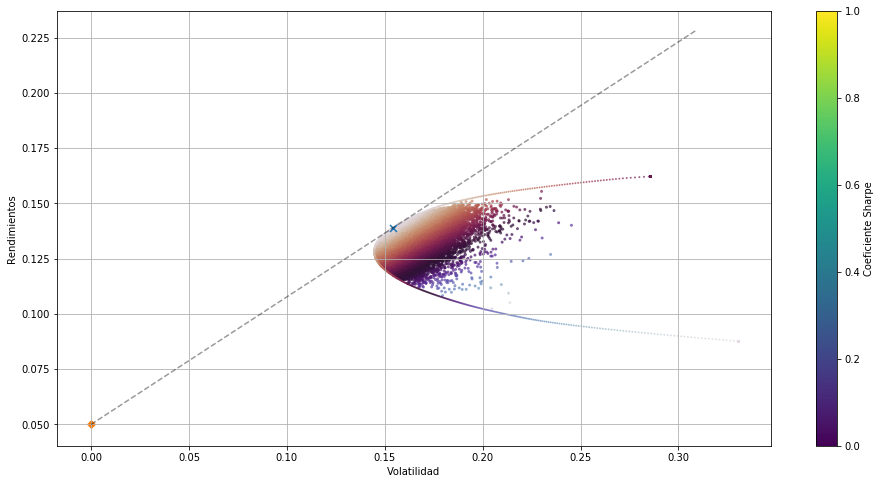

In [25]:
plt.figure(figsize=(16,8))
plt.scatter(pvols,prets,c=(prets-rf) / pvols, marker = 'o',s = 4,cmap = 'twilight',alpha = 0.6)
plt.scatter(volsf,rendsf,c= (rendsf-rf) / volsf, marker = '.',s = 4,cmap = 'twilight',alpha = 0.6)
plt.scatter(sharpe_opt[1],sharpe_opt[0], marker = 'x',s = 50,cmap = 'twilight',alpha = 1)
plt.scatter(0,rf,marker='D',s=30)
plt.plot(u,u_[0],c='black',alpha=.4,linestyle = '--') 
plt.grid(True)
plt.xlabel('Volatilidad')
plt.ylabel('Rendimientos')
plt.colorbar(label = 'Coeficiente Sharpe')
plt.show()


## Calcula el VaR paramétrico del portafolio riesgoso óptimo (1 día, 95% de confianza)

In [26]:
def VaR(mi,confianza,temp = 'diaria'):
    a = np.sqrt(np.dot(pond.T,np.dot(cov,pond)))
    d = np.sqrt(np.dot(pond.T,np.dot(cov_d,pond)))
    pvol = d if temp == 'diaria' else a
    VaR = mi * norm.ppf(0.95) * pvol
    return VaR,temp

In [27]:
print('El VaR {} es {:,.2f}'.format(VaR(mi,0.95 ,temp = 'diaria')[1],VaR(mi,0.95 ,temp = 'diaria')[0]))

El VaR diaria es 169,583.44


### BONUS POINT: 
Elige los porcentajes a invertir en el portafolio riesgoso óptimo y el activo
libre de riesgo (maximizar la función de utilidad)


In [28]:
# el óptimo para este ejercicio es sin opción a cortos (short = False)

In [29]:
def maxut(A): return (sharpe_opt[0] - rf) /  (A * sharpe_opt[1]**2)
def maxut2(A): return pr /  (A * sharpe_opt[1])
def rend_tot(y): return (1-y) * rf + y * sharpe_opt[0]
def std_tot(y): return y * sharpe_opt[1]

In [30]:
A = 3
y = maxut(A)
print(' y* donde se maximiza la utilidad: {:.3%}'.format(y))

 y* donde se maximiza la utilidad: 124.576%


In [31]:
print('Portafolio completo')
print('--------------------------')
print('Rendimiento Pc: {:.2%}'.format(rend_tot(y)))
print('Std Pc: {:.2%}'.format(std_tot(y)))

Portafolio completo
--------------------------
Rendimiento Pc: 16.10%
Std Pc: 19.23%


In [32]:
pesosopt = pd.DataFrame([x for x in opts['x']],index=titulos,columns=['Peso'])
PtfComp = pd.DataFrame({
    'Titulos': titulos,
    'Peso':[x for x in opts['x']],
    'peso_Pc': [x * y for x in opts['x']]
})
PtfComp.set_index('Titulos',inplace=True)
j = [[0,1-y]]
j = pd.DataFrame(j,columns = PtfComp.columns,index = ['LibreRiesgo'])
PtfComp = pd.concat([PtfComp,j])
PtfComp
PtfComp.style.format("{:.2%}")

,Peso,peso_Pc
ASURB,18.25%,22.73%
ELEKTRA*,5.51%,6.86%
GAPB,17.26%,21.50%
GMEXICOB,21.63%,26.95%
KIMBERA,19.60%,24.41%
PE&OLES*,7.40%,9.22%
ALPEKA,10.36%,12.90%
LibreRiesgo,0.00%,-24.58%
